## Практическое задание к уроку № 3 по теме "Связь бизнес-показателей и DS-метрик".

1. Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
3. Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
    - стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - стоимость теста 1400р
4. Сделать выводы о том, какая модель справилась с задачей лучше других
5. *Найти порог классификации по деньгам для лучшей модели
    - Стоимость лечения 15000р, если сделали тест и начали лечить вовремя
    - Стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
    - Стоимость теста 1400р

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('train_case2.csv', sep=';', index_col='id')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), 
                                                    df['cardio'], random_state=29)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion:

In [6]:
feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)

Инициализируем модели:

In [7]:
lr_model = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression())
])

knn_model = Pipeline([
    ('features', feats),
    ('classifier', KNeighborsClassifier())
])

rf_model = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=29))
])

Обозначим функцию для возвращения метрик и определения величины порога классификации, обеспечивающего максимальный f-score:

In [8]:
def find_best_metrics(y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}, ROC-AUC={roc_auc_score(y_test, y_score):.3f}')
    return thresholds[ix], round(fscore[ix], 3), round(precision[ix], 3), round(recall[ix], 3), round(roc_auc_score(y_test, y_score), 3)

Сделаем предсказания моделей:

In [9]:
lr_model.fit(X_train, y_train)
y_score_lr = lr_model.predict_proba(X_test)[:, 1]

knn_model.fit(X_train, y_train)
y_score_knn = knn_model.predict_proba(X_test)[:, 1]

rf_model.fit(X_train, y_train)
y_score_rf = rf_model.predict_proba(X_test)[:, 1]

Получим их метрики и значение порога при максимальном f1-score:

In [10]:
threshold_lr, fscore_lr, precision_lr, recall_lr, roc_auc_score_lr = find_best_metrics(y_test, y_score_lr)

Best Threshold=0.3785471809601794, F-Score=0.735, Precision=0.640, Recall=0.865, ROC-AUC=0.786


In [11]:
threshold_knn, fscore_knn, precision_knn, recall_knn, roc_auc_score_knn = find_best_metrics(y_test, y_score_knn)

Best Threshold=0.4, F-Score=0.689, Precision=0.592, Recall=0.824, ROC-AUC=0.694


In [12]:
threshold_rf, fscore_rf, precision_rf, recall_rf, roc_auc_score_rf = find_best_metrics(y_test, y_score_rf)

Best Threshold=0.38, F-Score=0.729, Precision=0.666, Recall=0.804, ROC-AUC=0.774


Оформим метрики в виде таблицы:

In [13]:
models = ['Logistic regression', 'k nearest neighbors', 'Random forest']
metrics = ['F-score', 'Precision', 'Recall', 'ROC-AUC']

data = np.array([[fscore_lr, precision_lr, recall_lr, roc_auc_score_lr],
                 [fscore_knn, precision_knn, recall_knn, roc_auc_score_knn],
                 [fscore_rf, precision_rf, recall_rf, roc_auc_score_rf]])
metrics_table = pd.DataFrame(data, index=models, columns=metrics)
metrics_table

,F-score,Precision,Recall,ROC-AUC
Logistic regression,0.735,0.640,0.865,0.786
k nearest neighbors,0.689,0.592,0.824,0.694
Random forest,0.729,0.666,0.804,0.774


Логистическая регрессия чуть опережает случайный лес, knn сильно от них отстаёт.  
Посмотрим, как модели покажут себя по бизнес-метрикам.

In [14]:
def calc_profit(y_test, y_score, threshold, 
                rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):
    
    cnf_matrix = confusion_matrix(y_test, y_score > threshold)
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]
    
    rubl_1 = (FN + TP) * rubl_late_treatment
    print('Расходы, если не делать тест и ждать симптомов:', rubl_1)
    
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
    print('Расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    print('Расходы, если использовать ML:', rubl_ML, end='\n\n')
    
    print('Разница:\n')
    
    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML)
    
    profit = min(rubl_1, rubl_test_all) - rubl_ML
    
    return profit

In [15]:
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

#### Логистическая регрессия:

In [16]:
profit_lr = calc_profit(y_test, y_score_lr, threshold_lr,
                        rubl_test, rubl_early_treatment, rubl_late_treatment)

Расходы, если не делать тест и ждать симптомов: 175820000
Расходы, если делать тест всем и лечить группу больных: 156365000
Расходы, если использовать ML: 154447000

Разница:

Расходы "решение не делать тесты - расходы с МL:" 21373000
Расходы "решение не делать тесты - расходы сделать тесты всем": 19455000
Расходы "сделать тесты всем - решение делать тесты ML": 1918000


#### kNN:

In [17]:
profit_knn = calc_profit(y_test, y_score_knn, threshold_knn,
                        rubl_test, rubl_early_treatment, rubl_late_treatment)

Расходы, если не делать тест и ждать симптомов: 175820000
Расходы, если делать тест всем и лечить группу больных: 156365000
Расходы, если использовать ML: 159847800

Разница:

Расходы "решение не делать тесты - расходы с МL:" 15972200
Расходы "решение не делать тесты - расходы сделать тесты всем": 19455000
Расходы "сделать тесты всем - решение делать тесты ML": -3482800


#### Random forest:

In [18]:
profit_rf = calc_profit(y_test, y_score_rf, threshold_rf,
                        rubl_test, rubl_early_treatment, rubl_late_treatment)

Расходы, если не делать тест и ждать симптомов: 175820000
Расходы, если делать тест всем и лечить группу больных: 156365000
Расходы, если использовать ML: 155444800

Разница:

Расходы "решение не делать тесты - расходы с МL:" 20375200
Расходы "решение не делать тесты - расходы сделать тесты всем": 19455000
Расходы "сделать тесты всем - решение делать тесты ML": 920200


#### Итог:

In [19]:
profits = np.array([profit_lr, profit_knn, profit_rf])
profits_table = pd.DataFrame(profits, index=models, columns=['Profit'])
profits_table

,Profit
Logistic regression,1918000
k nearest neighbors,-3482800
Random forest,920200


Применение kNN обходится дороже, чем делать тесты всем. Наибольшую прибыль  
с принятыми порогами классификации приносит модель логистической регрессии.

Немного отступлю от условия домашней работы, где нужно найти порог классификации  
по деньгам для лучшей на данный момент модели, так как для логистической регрессии  
мы находили порог на уроке.  
Посмотрим, сможет ли модель случайного леса подобраться к показателям логистической  
регрессии по деньгам:

In [20]:
def business_threshold_calibrate(y_test, y_score, thresholds_range,
                                 rubl_test=100, rubl_early_treatment=100, rubl_late_treatment=1000):

    rubl_ML_ = np.inf

    rs = []
    for opt_business_tr in thresholds_range:
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_business_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        rubl_1 = (TP + FN) * rubl_late_treatment
        rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment
        rubl_ML = (TP + FP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_business_tr
            
            rubl_ML_ = rubl_ML
            
        rs.append(rubl_ML)   
            
    profit = min(rubl_1, rubl_test_all) - rubl_ML_
    
    print('расходы, если не делать тест и ждать симптомов:', rubl_1)
    print('расходы, если делать тест всем и лечить группу больных:', rubl_test_all)
    print('расходы, если использовать ML:', rubl_ML_)

    print('Расходы "решение не делать тесты - расходы с МL:"', rubl_1 - rubl_ML_)
    print('Расходы "решение не делать тесты - расходы сделать тесты всем":', rubl_1 - rubl_test_all)
    print('Расходы "сделать тесты всем - решение делать тесты ML":', rubl_test_all - rubl_ML_)
    
    plt.rcParams.update({'font.size': 14})
    plt.title('Потери при ML-решении')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(thresholds_range, rs)
    plt.grid()
    plt.show()
    
    return business_threshold, profit

расходы, если не делать тест и ждать симптомов: 175820000
расходы, если делать тест всем и лечить группу больных: 156365000
расходы, если использовать ML: 155003200
Расходы "решение не делать тесты - расходы с МL:" 20816800
Расходы "решение не делать тесты - расходы сделать тесты всем": 19455000
Расходы "сделать тесты всем - решение делать тесты ML": 1361800


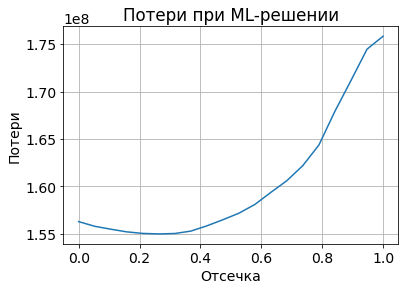

In [21]:
thresholds_range = np.linspace(0, 1, 20)
business_threshold_rf, new_profit_rf = business_threshold_calibrate(y_test, y_score_rf, thresholds_range,
                                                                    rubl_test, rubl_early_treatment, rubl_late_treatment)

Дополнительная прибыль от настройки значения порога:

In [22]:
new_profit_rf - profit_rf

441600

Попробуем более тонко настроить порог - возмём диапазон поиска от 0,2 до 0,4:

расходы, если не делать тест и ждать симптомов: 175820000
расходы, если делать тест всем и лечить группу больных: 156365000
расходы, если использовать ML: 154977200
Расходы "решение не делать тесты - расходы с МL:" 20842800
Расходы "решение не делать тесты - расходы сделать тесты всем": 19455000
Расходы "сделать тесты всем - решение делать тесты ML": 1387800


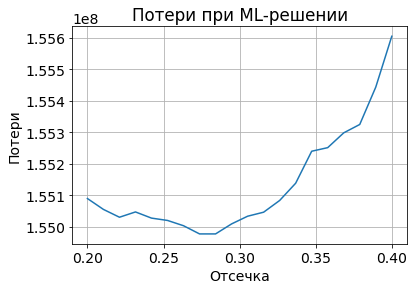

In [23]:
thresholds_range = np.linspace(0.2, 0.4, 20)
business_threshold_rf, new_profit_rf = business_threshold_calibrate(y_test, y_score_rf, thresholds_range,
                                                                    rubl_test, rubl_early_treatment, rubl_late_treatment)

Теперь дополнительная прибыль от настройки значения порога:

In [24]:
new_profit_rf - profit_rf

467600

Сравним значения порогов по f1-метрике и по бизнес-метрике:

In [25]:
print('Уровень порога по бизнес-метрике', business_threshold_rf)
print('Уровень порога по f1-метрике', threshold_rf)

Уровень порога по бизнес-метрике 0.2736842105263158
Уровень порога по f1-метрике 0.38


Посмотрим, на сколько мы всё ещё отстаём от модели логистической регрессии,  
у которой значение порога настраивалось только по максимальному f1-score:

In [26]:
new_profit_rf - profit_lr

-530200